In [1]:
!pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.7 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import Adam
from keras_unet_collection import models, losses
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LOAD IMAGES AND MASK
### Create a dataframe using pandas which is contain image path and mask path

### Preprocessing images and mask dataset in this below link

[https://www.kaggle.com/code/greedyfornothing/sennet-hoa-preprocessing-images-and-mask/notebook](http://)

In [3]:
train_base_path = '/kaggle/input/sennet-hoa-512x512-images/img_512x512/'
train_new_images_path = os.path.join(train_base_path, 'images')
train_new_masks_path = os.path.join(train_base_path, 'masks')

train_image512x512_files = sorted([os.path.join(train_new_images_path, file) for file in os.listdir(train_new_images_path) if os.path.isfile(os.path.join(train_new_images_path, file))])
train_mask512x512_files = sorted([os.path.join(train_new_masks_path, file) for file in os.listdir(train_new_masks_path) if os.path.isfile(os.path.join(train_new_masks_path, file))])


print("Image files:")
print(len(train_image512x512_files), type(train_image512x512_files))

print("\nMask files:")
print(len(train_mask512x512_files), type(train_mask512x512_files))

Image files:
5542 <class 'list'>

Mask files:
5542 <class 'list'>


In [4]:
val_base_path = '/kaggle/input/sennet-hoa-512x512-images/val_img_512x512/'
val_new_images_path = os.path.join(val_base_path, 'images')
val_new_masks_path = os.path.join(val_base_path, 'masks')

val_image512x512_files = sorted([os.path.join(val_new_images_path, file) for file in os.listdir(val_new_images_path) if os.path.isfile(os.path.join(val_new_images_path, file))])
val_mask512x512_files = sorted([os.path.join(val_new_masks_path, file) for file in os.listdir(val_new_masks_path) if os.path.isfile(os.path.join(val_new_masks_path, file))])


print("Image files:")
print(len(val_image512x512_files), type(val_image512x512_files))

print("\nMask files:")
print(len(val_mask512x512_files), type(val_mask512x512_files))

Image files:
1386 <class 'list'>

Mask files:
1386 <class 'list'>


In [5]:
new_df = pd.DataFrame(list(zip(train_image512x512_files, train_mask512x512_files)), columns = ["image path", "mask path"])
new_df.to_csv("new_df_train_path.csv")

In [6]:
new_df.head()

,image path,mask path
0,/kaggle/input/sennet-hoa-512x512-images/img_51...,/kaggle/input/sennet-hoa-512x512-images/img_51...
1,/kaggle/input/sennet-hoa-512x512-images/img_51...,/kaggle/input/sennet-hoa-512x512-images/img_51...
2,/kaggle/input/sennet-hoa-512x512-images/img_51...,/kaggle/input/sennet-hoa-512x512-images/img_51...
3,/kaggle/input/sennet-hoa-512x512-images/img_51...,/kaggle/input/sennet-hoa-512x512-images/img_51...
4,/kaggle/input/sennet-hoa-512x512-images/img_51...,/kaggle/input/sennet-hoa-512x512-images/img_51...


In [7]:
val_new_df = pd.DataFrame(list(zip(val_image512x512_files, val_mask512x512_files)), columns = ["image path", "mask path"])
val_new_df.to_csv("val_new_df_train_path.csv")

In [8]:
val_new_df.head()

,image path,mask path
0,/kaggle/input/sennet-hoa-512x512-images/val_im...,/kaggle/input/sennet-hoa-512x512-images/val_im...
1,/kaggle/input/sennet-hoa-512x512-images/val_im...,/kaggle/input/sennet-hoa-512x512-images/val_im...
2,/kaggle/input/sennet-hoa-512x512-images/val_im...,/kaggle/input/sennet-hoa-512x512-images/val_im...
3,/kaggle/input/sennet-hoa-512x512-images/val_im...,/kaggle/input/sennet-hoa-512x512-images/val_im...
4,/kaggle/input/sennet-hoa-512x512-images/val_im...,/kaggle/input/sennet-hoa-512x512-images/val_im...


# I'll try using ImageDataGenerator
let's try using ImageDataGenerator from Tensorflow

In [9]:
input_size = (512,512)
batch_size = 8

#no data augmentation
std_img_data_gen = ImageDataGenerator(rescale=1./255)
std_mask_data_gen = ImageDataGenerator()

#with data augmentation
img_data_gen_args = dict(rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    rescale=1./255)

mask_data_gen_args = dict(rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)


def image_mask_dataset(df, img_path_name, mask_path_name, target_size, batch):
#     img_gen = ImageDataGenerator(**img_data_gen_args)
#     mask_gen = ImageDataGenerator(**mask_data_gen_args)
    
    img_data = std_img_data_gen.flow_from_dataframe(dataframe = df,
                                          x_col = img_path_name,
                                          target_size = target_size, 
                                          class_mode = None,
                                          color_mode = 'rgb', 
                                          batch_size = batch,
                                          seed = 42)
    mask_data = std_mask_data_gen.flow_from_dataframe(dataframe = df, x_col = mask_path_name, target_size = target_size,
                                           class_mode = None, batch_size = batch, color_mode = 'grayscale',
                                           seed = 42)
    
    datagen = zip(img_data, mask_data)
    return datagen

# def image_mask_val_dataset(df, img_path_name, mask_path_name, target_size, batch):    
#     img_data = std_img_data_gen.flow_from_dataframe(dataframe = df,
#                                           x_col = img_path_name,
#                                           target_size = target_size,
#                                           class_mode = None,
#                                           color_mode = 'rgb',
#                                           batch_size = batch,
#                                           seed = 42)
#     mask_data = std_mask_data_gen.flow_from_dataframe(dataframe = df,
#                                           x_col = mask_path_name,
#                                           target_size = target_size,
#                                           class_mode = None,
#                                           color_mode = 'grayscale',
#                                           batch_size = batch,
#                                           seed = 42)
#     datagen = zip(img_data, mask_data)
#     return datagen

In [10]:
data_training = image_mask_dataset(df = new_df, img_path_name = "image path", mask_path_name = "mask path",
                             target_size = input_size, batch = batch_size)

data_validation = image_mask_dataset(df = val_new_df, img_path_name = "image path", mask_path_name = "mask path",
                                target_size = input_size, batch = batch_size)

Found 5542 validated image filenames.
Found 5542 validated image filenames.
Found 1386 validated image filenames.
Found 1386 validated image filenames.


> ## the batch information

In [11]:
sample_batch = next(data_training)
img_batch, mask_batch = sample_batch

print("Image Batch Shape:", img_batch.shape, "\nImage Batch max value:", img_batch.max())
print("\nMask Batch Shape:", mask_batch.shape, "\nMask Batch max value:", mask_batch.max())

Image Batch Shape: (8, 512, 512, 3) 
Image Batch max value: 1.0

Mask Batch Shape: (8, 512, 512, 1) 
Mask Batch max value: 1.0


In [12]:
val_sample_batch = next(data_validation)
val_img_batch, val_mask_batch = val_sample_batch

print("Image Batch Shape:", val_img_batch.shape, "\nImage Batch max value:", val_img_batch.max())
print("\nMask Batch Shape:", val_mask_batch.shape, "\nMask Batch max value:", val_mask_batch.max())

Image Batch Shape: (8, 512, 512, 3) 
Image Batch max value: 1.0

Mask Batch Shape: (8, 512, 512, 1) 
Mask Batch max value: 1.0


# PLOT SAMPLE BATCH IMAGES

In [13]:
def display_images_with_masks(img_batch, mask_batch, target_size, num_rows=2, num_cols=5):
    plt.figure(figsize=(15, 7))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < len(img_batch):
                plt.subplot(num_rows, 2 * num_cols, 2 * idx + 1)
                plt.imshow(img_batch[idx])
                plt.axis('off')
                plt.title('Image')

                plt.subplot(num_rows, 2 * num_cols, 2 * idx + 2)
                plt.imshow(mask_batch[idx].reshape(target_size[0], target_size[1]), cmap='gray')
                plt.axis('off')
                plt.title('Mask')
    
    plt.tight_layout()
    plt.show()

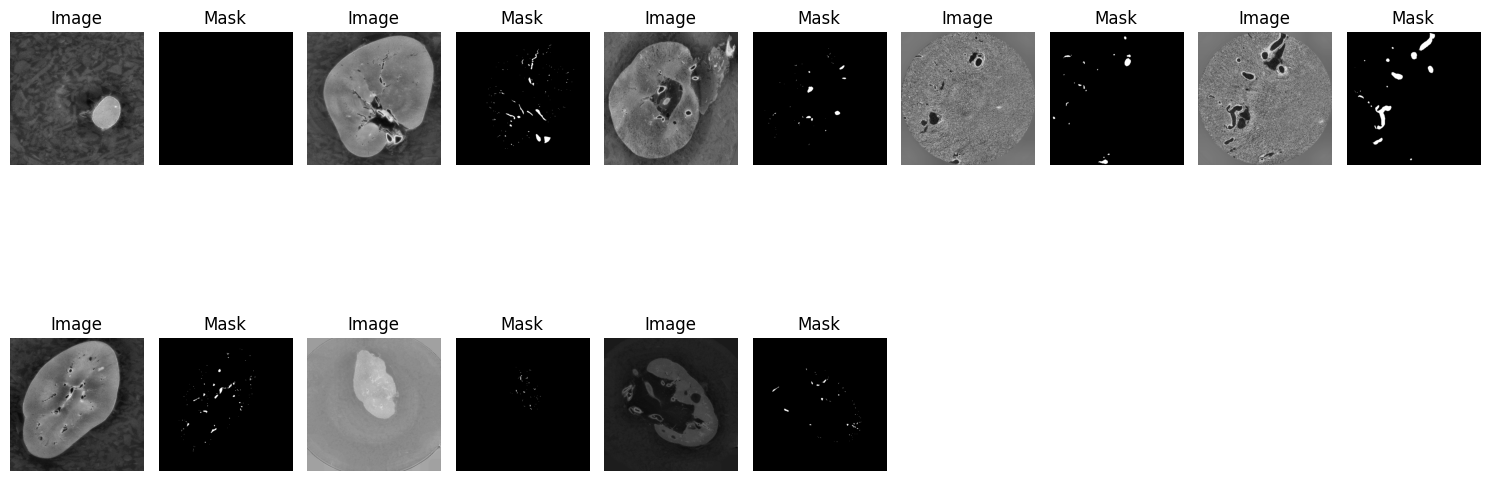

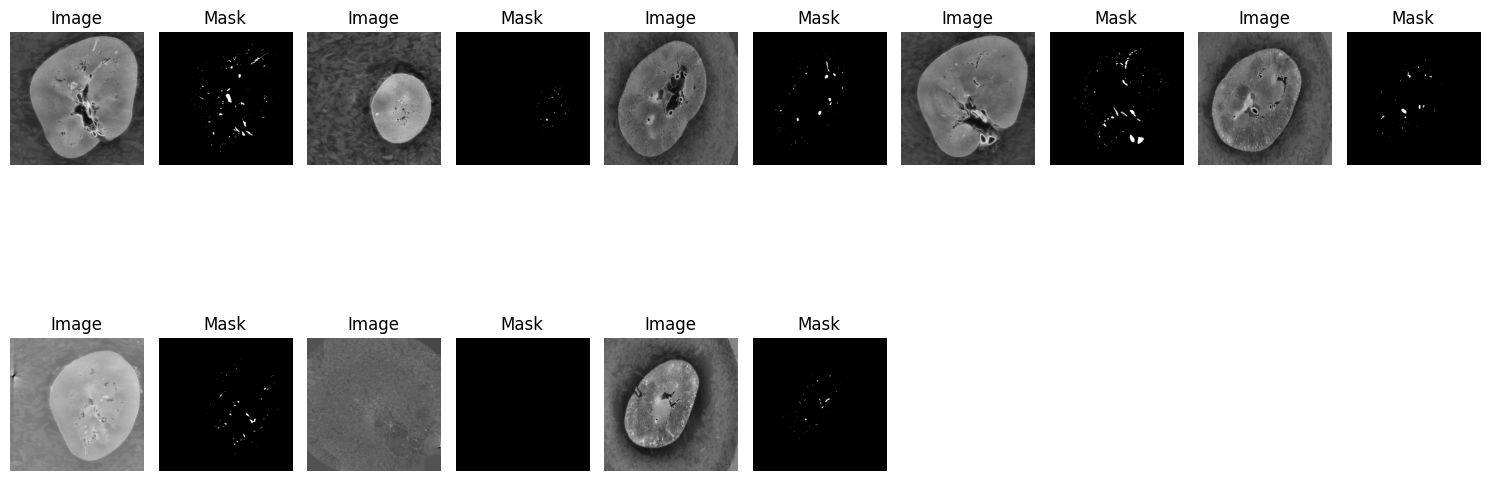

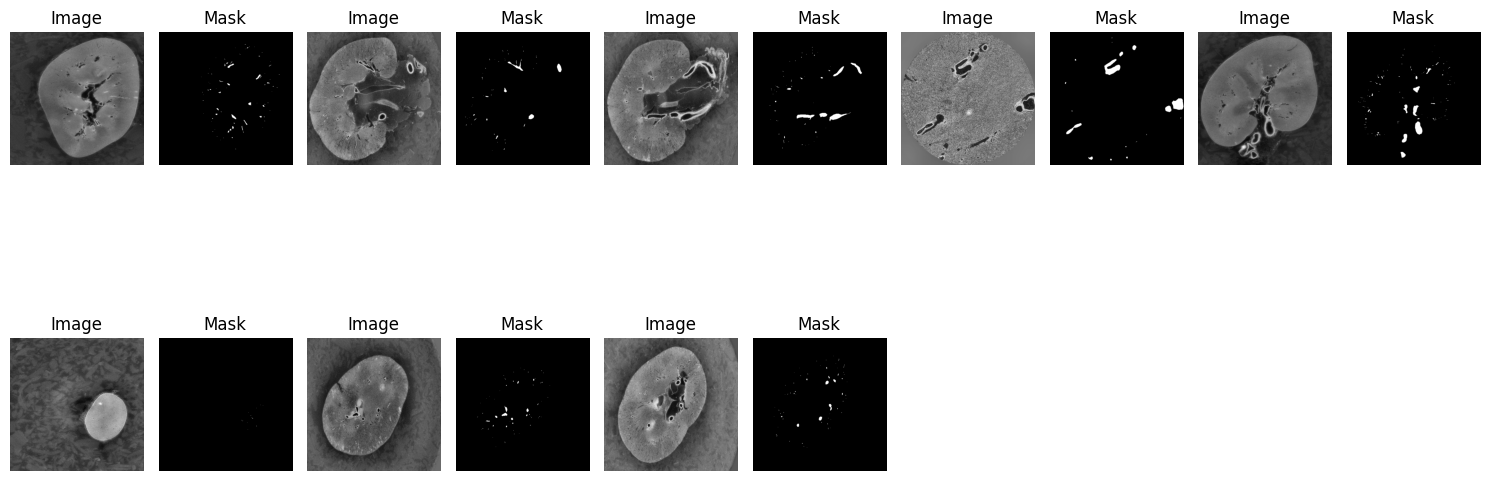

In [14]:
num_images_to_display = 3

for i, (img_batch, mask_batch) in enumerate(data_training):
    if i == num_images_to_display:
        break
        
    display_images_with_masks(img_batch, mask_batch, target_size=input_size)

# MODEL by Keras UNet Collection
model UNet2D + VGG16 + weight "imagenet"

[https://github.com/yingkaisha/keras-unet-collection](http://)

In [15]:
help(models.unet_2d)

Help on function unet_2d in module keras_unet_collection._model_unet_2d:

unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_s

In [16]:
model_Unet = models.unet_2d((512, 512, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=1, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet')

/opt/conda/lib/python3.10/site-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 [==============================] - 0s 0us/step


In [17]:
model_Unet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', losses.dice_coef])

In [18]:
print(model_Unet.summary())

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 VGG16_backbone (Functional  [(None, 512, 512, 64),       1471468   ['input_1[0][0]']             
 )                            (None, 256, 256, 128),      8                                       
                              (None, 128, 128, 256),                                              
                              (None, 64, 64, 512),                                                
                              (None, 32, 32, 512)]                                                
                                                                                         

In [19]:
start1 = datetime.now() 

Unet_history = model_Unet.fit(data_training, 
                    verbose=1,
                    steps_per_epoch = 693,
                    validation_data=data_validation,
                    validation_steps = 173,
                    shuffle=False,
                    epochs=5)

model_Unet.save('SenNet_HOA_5_epochs.hdf5')
stop1 = datetime.now()

Epoch 1/5
693/693 [==============================] - 709s 981ms/step - loss: 0.0191 - accuracy: 0.9971 - dice_coef: 0.5364 - val_loss: 0.0051 - val_accuracy: 0.9985 - val_dice_coef: 0.7531
Epoch 2/5
693/693 [==============================] - 662s 956ms/step - loss: 0.0036 - accuracy: 0.9990 - dice_coef: 0.8222 - val_loss: 0.0034 - val_accuracy: 0.9991 - val_dice_coef: 0.8051
Epoch 3/5
693/693 [==============================] - 663s 956ms/step - loss: 0.0027 - accuracy: 0.9992 - dice_coef: 0.8728 - val_loss: 0.0062 - val_accuracy: 0.9980 - val_dice_coef: 0.7576
Epoch 4/5
693/693 [==============================] - 663s 956ms/step - loss: 0.0023 - accuracy: 0.9992 - dice_coef: 0.8909 - val_loss: 0.0022 - val_accuracy: 0.9993 - val_dice_coef: 0.8960
Epoch 5/5
693/693 [==============================] - 663s 957ms/step - loss: 0.0021 - accuracy: 0.9993 - dice_coef: 0.9039 - val_loss: 0.0018 - val_accuracy: 0.9994 - val_dice_coef: 0.9075


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

UNet execution time is:  0:56:01.075101
